# WGAN-GP 실습

- 논문제목 : Improved Training of Wasserstein GANs
- 학습 데이터셋: MINST (1x28x28)

## 필요한 라이브러리 불러오기

In [1]:
import os
import numpy as np
import math
import sys
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
from torchvision.utils import save_image

import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
cuda = True if torch.cuda.is_available() else False
print(device)

cuda


In [3]:
latent_dim = 100
img_shape = (1, 28, 28)

In [4]:
save_path = 'wgangp_save/'
dataset = 'MNIST'
data_path = 'wgangp'

In [5]:
if not os.path.isdir(data_path):
    os.makedirs(data_path)
if not os.path.isdir(os.path.join(save_path, dataset)):
    os.makedirs(os.path.join(save_path, dataset))

In [6]:
denormalize = lambda x: x*0.5+0.5

## 학습 데이터셋 불러오기
- 학습을 위해 MNIST 데이터셋을 불러옵니다.

In [7]:
transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],std=[0.5])
])
train_dataset = datasets.MNIST(root="./wgangp", train=True,download = True, transform=transforms_train)
dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)

In [8]:
def plot(x):
    img = (np.array(x.detach().cpu(), dtype='float')).reshape(28,28)

    plt.imshow(img, cmap='gray')
    plt.show()

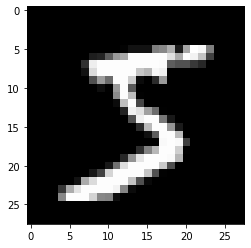

In [9]:
plot(train_dataset.data[0])

## models

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        
        # 하나의 블록(block) 정의
        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # 생성자 모델은 연속적인 여러 개의 블록을 가짐
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        output = self.model(flattened)
        
        return output

In [12]:
# Loss weight for gradient penalty
lambda_gp = 10

In [13]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

lr = 0.0002

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [14]:
generator.model

Sequential(
  (0): Linear(in_features=100, out_features=128, bias=True)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Linear(in_features=256, out_features=512, bias=True)
  (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Linear(in_features=512, out_features=1024, bias=True)
  (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Linear(in_features=1024, out_features=784, bias=True)
  (12): Tanh()
)

In [15]:
discriminator.model

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2, inplace=True)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

## Loss function

In [16]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penealty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    epsilon = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (epsilon * real_samples + ((1 - epsilon) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0),  requires_grad=False)
    # Get gradient w.r.t interpolates
    gradients = autograd.grad(
        outputs = d_interpolates,
        inputs = interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) -1)**2).mean()
    return gradient_penalty

## Training

In [19]:
n_epochs = 200
n_critic = 5
log_interval = 100
g_loss_list = []
d_loss_list = []

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        
        # Configure input
        real_imgs = Variable(imgs.type(Tensor))
        
        # ====================================================#
        #                Train Discriminator                  #
        # ====================================================#
        
        optimizer_D.zero_grad()
        
        # samplenoise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
        
        # Generate a batch of images
        fake_imgs = generator(z)
        
        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)
        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
        
        d_loss.backward()
        optimizer_D.step()
        
        # ====================================================#
        #                   Train Generator                   #
        # ====================================================#
        
        optimizer_G.zero_grad()
        
        # Train the generator every n_critic steps
        if i % n_critic == 0:
            
            # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)
            
            g_loss.backward()
            optimizer_G.step()
            
        if (i+1) % log_interval == 0:
            g_loss_list.append(g_loss.item())
            d_loss_list.append(d_loss.item())
            print('Epoch [{}/{}] Batch [{}/{}] Discriminator loss: {:.4f} Generator loss: {:.4f}'.format(
                epoch+1, n_epochs, i+1, len(dataloader), d_loss.item(), g_loss.item()))
    

Epoch [1/200] Batch [100/938] Discriminator loss: 1.1726 Generator loss: -0.2040
Epoch [1/200] Batch [200/938] Discriminator loss: 0.9206 Generator loss: -0.1948
Epoch [1/200] Batch [300/938] Discriminator loss: 1.1392 Generator loss: -0.2407
Epoch [1/200] Batch [400/938] Discriminator loss: 0.9955 Generator loss: -0.3857
Epoch [1/200] Batch [500/938] Discriminator loss: 0.6085 Generator loss: -0.2431
Epoch [1/200] Batch [600/938] Discriminator loss: 1.0156 Generator loss: -0.4676
Epoch [1/200] Batch [700/938] Discriminator loss: 0.6793 Generator loss: -0.3290
Epoch [1/200] Batch [800/938] Discriminator loss: 0.2908 Generator loss: -0.1783
Epoch [1/200] Batch [900/938] Discriminator loss: 0.5210 Generator loss: -0.2862
Epoch [2/200] Batch [100/938] Discriminator loss: 0.4732 Generator loss: -0.3284
Epoch [2/200] Batch [200/938] Discriminator loss: 0.0802 Generator loss: -0.1952
Epoch [2/200] Batch [300/938] Discriminator loss: 0.0142 Generator loss: -0.3600
Epoch [2/200] Batch [400/938

Epoch [12/200] Batch [300/938] Discriminator loss: -0.2798 Generator loss: -0.3241
Epoch [12/200] Batch [400/938] Discriminator loss: -0.0637 Generator loss: -0.5279
Epoch [12/200] Batch [500/938] Discriminator loss: -0.2449 Generator loss: -0.2846
Epoch [12/200] Batch [600/938] Discriminator loss: 0.0667 Generator loss: -0.5396
Epoch [12/200] Batch [700/938] Discriminator loss: -0.2691 Generator loss: -0.3626
Epoch [12/200] Batch [800/938] Discriminator loss: -0.1798 Generator loss: -0.4454
Epoch [12/200] Batch [900/938] Discriminator loss: -0.0651 Generator loss: -0.3540
Epoch [13/200] Batch [100/938] Discriminator loss: -0.2677 Generator loss: -0.3197
Epoch [13/200] Batch [200/938] Discriminator loss: -0.2041 Generator loss: -0.3337
Epoch [13/200] Batch [300/938] Discriminator loss: -0.2438 Generator loss: -0.3536
Epoch [13/200] Batch [400/938] Discriminator loss: -0.2091 Generator loss: -0.3235
Epoch [13/200] Batch [500/938] Discriminator loss: 0.2607 Generator loss: -0.5174
Epoch 

Epoch [23/200] Batch [300/938] Discriminator loss: -0.2715 Generator loss: -0.3272
Epoch [23/200] Batch [400/938] Discriminator loss: -0.1949 Generator loss: -0.3845
Epoch [23/200] Batch [500/938] Discriminator loss: -0.2193 Generator loss: -0.2433
Epoch [23/200] Batch [600/938] Discriminator loss: -0.2149 Generator loss: -0.3562
Epoch [23/200] Batch [700/938] Discriminator loss: -0.1838 Generator loss: -0.3348
Epoch [23/200] Batch [800/938] Discriminator loss: 0.1915 Generator loss: -0.0895
Epoch [23/200] Batch [900/938] Discriminator loss: -0.2221 Generator loss: -0.5677
Epoch [24/200] Batch [100/938] Discriminator loss: -0.2789 Generator loss: -0.4234
Epoch [24/200] Batch [200/938] Discriminator loss: -0.1423 Generator loss: -0.5443
Epoch [24/200] Batch [300/938] Discriminator loss: -0.2042 Generator loss: -0.3088
Epoch [24/200] Batch [400/938] Discriminator loss: -0.2125 Generator loss: -0.3476
Epoch [24/200] Batch [500/938] Discriminator loss: 9.9984 Generator loss: -0.0000
Epoch 

Epoch [34/200] Batch [300/938] Discriminator loss: -0.1283 Generator loss: -0.3752
Epoch [34/200] Batch [400/938] Discriminator loss: -0.2242 Generator loss: -0.3907
Epoch [34/200] Batch [500/938] Discriminator loss: -0.1760 Generator loss: -0.3153
Epoch [34/200] Batch [600/938] Discriminator loss: 0.0599 Generator loss: -0.4509
Epoch [34/200] Batch [700/938] Discriminator loss: -0.1165 Generator loss: -0.3903
Epoch [34/200] Batch [800/938] Discriminator loss: -0.1837 Generator loss: -0.3336
Epoch [34/200] Batch [900/938] Discriminator loss: -0.2037 Generator loss: -0.3717
Epoch [35/200] Batch [100/938] Discriminator loss: -0.1964 Generator loss: -0.3598
Epoch [35/200] Batch [200/938] Discriminator loss: -0.1125 Generator loss: -0.4449
Epoch [35/200] Batch [300/938] Discriminator loss: 8.6906 Generator loss: -0.9947
Epoch [35/200] Batch [400/938] Discriminator loss: -0.1612 Generator loss: -0.3839
Epoch [35/200] Batch [500/938] Discriminator loss: -0.2002 Generator loss: -0.4787
Epoch 

KeyboardInterrupt: 